# Assignment Module 2: Product Classification

The goal of this assignment is to implement a neural network that classifies smartphone pictures of products found in grocery stores. The assignment will be divided into two parts: first, you will be asked to implement from scratch your own neural network for image classification; then, you will fine-tune a pretrained network provided by PyTorch.


## Preliminaries: the dataset

The dataset you will be using contains natural images of products taken with a smartphone camera in different grocery stores:

<p align="center">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Granny-Smith.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Pink-Lady.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Lemon.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Banana.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Vine-Tomato.jpg" width="150">
</p>
<p align="center">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Yellow-Onion.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Green-Bell-Pepper.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Arla-Standard-Milk.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Oatly-Natural-Oatghurt.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Alpro-Fresh-Soy-Milk.jpg" width="150">
</p>

The products belong to the following 43 classes:
```
0.  Apple
1.  Avocado
2.  Banana
3.  Kiwi
4.  Lemon
5.  Lime
6.  Mango
7.  Melon
8.  Nectarine
9.  Orange
10. Papaya
11. Passion-Fruit
12. Peach
13. Pear
14. Pineapple
15. Plum
16. Pomegranate
17. Red-Grapefruit
18. Satsumas
19. Juice
20. Milk
21. Oatghurt
22. Oat-Milk
23. Sour-Cream
24. Sour-Milk
25. Soyghurt
26. Soy-Milk
27. Yoghurt
28. Asparagus
29. Aubergine
30. Cabbage
31. Carrots
32. Cucumber
33. Garlic
34. Ginger
35. Leek
36. Mushroom
37. Onion
38. Pepper
39. Potato
40. Red-Beet
41. Tomato
42. Zucchini
```

The dataset is split into training (`train`), validation (`val`), and test (`test`) set.

The following code cells download the dataset and define a `torch.utils.data.Dataset` class to access it. This `Dataset` class will be the starting point of your assignment: use it in your own code and build everything else around it.

In [48]:
!git clone https://github.com/marcusklasson/GroceryStoreDataset.git

Cloning into 'GroceryStoreDataset'...
fatal: unable to access 'https://github.com/marcusklasson/GroceryStoreDataset.git/': Could not resolve host: github.com


In [49]:
from pathlib import Path
from PIL import Image
from torch import Tensor
from torch.utils.data import Dataset
from typing import List, Tuple

In [50]:
class GroceryStoreDataset(Dataset):

    def __init__(self, split: str, transform=None) -> None:
        super().__init__()

        self.root = Path("/kaggle/input/titles/GroceryStoreDataset-master/dataset")
        self.split = split
        self.paths, self.labels = self.read_file()

        self.transform = transform

    def __len__(self) -> int:
        return len(self.labels)

    def __getitem__(self, idx) -> Tuple[Tensor, int]:
        img = Image.open(self.root / self.paths[idx])
        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        return img, label

    def read_file(self) -> Tuple[List[str], List[int]]:
        paths = []
        labels = []

        with open(self.root / f"{self.split}.txt") as f:
            for line in f:
                # path, fine-grained class, coarse-grained class
                path, _, label = line.replace("\n", "").split(", ")
                paths.append(path), labels.append(int(label))

        return paths, labels

    def get_num_classes(self) -> int:
        return max(self.labels) + 1

## Part 1: design your own network

Your goal is to implement a convolutional neural network for image classification and train it on `GroceryStoreDataset`. You should consider yourselves satisfied once you obtain a classification accuracy on the **validation** split of **around 60%**. You are free to achieve that however you want, except for a few rules you must follow:

- You **cannot** simply instantiate an off-the-self PyTorch network. Instead, you must construct your network as a composition of existing PyTorch layers. In more concrete terms, you can use e.g. `torch.nn.Linear`, but you **cannot** use e.g. `torchvision.models.alexnet`.

- Justify every *design choice* you make. Design choices include network architecture, training hyperparameters, and, possibly, dataset preprocessing steps. You can either (i) start from the simplest convolutional network you can think of and add complexity one step at a time, while showing how each step gets you closer to the target ~60%, or (ii) start from a model that is already able to achieve the desired accuracy and show how, by removing some of its components, its performance drops (i.e. an *ablation study*). You can *show* your results/improvements however you want: training plots, console-printed values or tables, or whatever else your heart desires: the clearer, the better.

Don't be too concerned with your network performance: the ~60% is just to give you an idea of when to stop. Keep in mind that a thoroughly justified model with lower accuracy will be rewarded **more** points than a poorly experimentally validated model with higher accuracy.

### data preprocessing and augmentation
In this first step we transform both the train and the validation sets, this is done because we want to do some augmentation in order to reduce the bias of the network.

In [51]:
# part one, data preprocessing and augmentation
import torchvision.transforms as transforms

# Data augmentation and normalization
train_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [52]:
def evaluate_model_on_test_set(model, test_loader, criterion):
    """
    Evaluate the model on the test set.

    Args:
        model (nn.Module): Trained model to be evaluated.
        test_loader (DataLoader): DataLoader for the test dataset.
        criterion (nn.Module): Loss function to calculate test loss.

    Returns:
        test_loss (float): Average loss on the test set.
        test_accuracy (float): Accuracy on the test set.
    """
    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0
    test_corrects = 0
    total_samples = 0

    with torch.no_grad():  # Disable gradient calculation for evaluation
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            # Calculate loss
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)

            # Calculate accuracy
            _, preds = torch.max(outputs, 1)
            test_corrects += torch.sum(preds == labels.data)
            total_samples += labels.size(0)

    test_loss = test_loss / total_samples
    test_accuracy = test_corrects.double() / total_samples

    print(f'Test Loss: {test_loss:.4f} | Test Accuracy: {test_accuracy:.4f}')
    return test_loss, test_accuracy


In [53]:
import matplotlib.pyplot as plt

def plot_accuracy(train_acc, val_acc):
    
    epochs = range(1, len(train_acc) + 1)

    plt.figure(figsize=(8, 6))
    plt.plot(epochs, train_acc, 'b', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()
    
def plot_loss(train_loss, val_loss):
    epochs = range(1, len(train_loss) + 1)

    plt.figure(figsize=(8, 6))
    plt.plot(epochs, train_loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()


### definition of training function
Here we define the training function. It takes as input the model, the train and val loader, as well as the criterion, optimizer, scheduler, number of epochs and patience. The total number of epoch is set to 20, although if there is no improvement after 5 steps the model stops training. At each epoch, we train on the train set and then evaluate the performance on the validation step.

In [54]:
def train_model_with_early_stopping_and_scheduler(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=20, patience=5):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    epochs_no_improve = 0
    early_stop = False
    
    train_loss_arr = []
    train_acc_arr = []
    val_loss_arr = []
    val_acc_arr = []
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        
        # Training phase
        model.train()
        running_loss = 0.0
        running_corrects = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        
        train_loss_arr.append(epoch_loss)
        train_acc_arr.append(epoch_acc)

        print(f'Training Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_corrects = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                _, preds = torch.max(outputs, 1)
                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels.data)
        
        val_loss = val_loss / len(val_loader.dataset)
        val_acc = val_corrects.double() / len(val_loader.dataset)
        
        val_loss_arr.append(val_loss)
        val_acc_arr.append(val_acc)

        print(f'Validation Loss: {val_loss:.4f} Acc: {val_acc:.4f}')

        # Check if early stopping condition is met
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print("Early stopping triggered")
            early_stop = True
            break

        # Step the learning rate scheduler
        scheduler.step()

        print("-" * 20)

    # Restore best model weights
    print(f"Best val Acc: {best_acc:.4f}")
    model.load_state_dict(best_model_wts)
    return model, train_loss_arr, train_acc_arr, val_loss_arr, val_acc_arr


In [55]:
# Label Smoothing Cross Entropy Loss
class LabelSmoothingLoss(nn.Module):
    def __init__(self, smoothing=0.1):
        super(LabelSmoothingLoss, self).__init__()
        self.smoothing = smoothing

    def forward(self, pred, target):
        # Get number of classes
        num_classes = pred.size(1)
        
        # Create smoothed labels
        with torch.no_grad():
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (num_classes - 1))
            true_dist.scatter_(1, target.data.unsqueeze(1), 1.0 - self.smoothing)
        
        return torch.mean(torch.sum(-true_dist * F.log_softmax(pred, dim=1), dim=1))

### definition of the network
The following is a CNN which is called EnhancedCNN because its predecessor, the SimpleCNN, of course was extremely basic and didn't perform as well. 
This network uses 2d convolutions, with 64, 128, 256, 512 filters. We choose the convolutional layers because it was requested by the task assignment (aka, build a convolutional neural network). The activation function is ReLU. 

We also use batch normalization and max pooling after the convolutional layers. Batch normalization is used specifically because it speeds up convergence and improves generalization. 

In [56]:
import torch.nn as nn
import torch.nn.functional as F

class EnhancedCNN(nn.Module):
    def __init__(self, num_classes):
        super(EnhancedCNN, self).__init__()
        # First convolutional block
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.batchnorm1 = nn.BatchNorm2d(64)
        self.batchnorm2 = nn.BatchNorm2d(128)

        # Second convolutional block
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.batchnorm3 = nn.BatchNorm2d(256)
        self.batchnorm4 = nn.BatchNorm2d(512)

        # Global Average Pooling layer instead of flattening
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))  # Output size of 1x1

        # Fully connected layers
        self.fc1 = nn.Linear(512, 1024)  # Adjust based on the output from the global avg pooling
        self.fc2 = nn.Linear(1024, num_classes)

        # Regularization
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # First block
        x = self.pool(F.relu(self.batchnorm1(self.conv1(x))))
        x = self.pool(F.relu(self.batchnorm2(self.conv2(x))))

        # Second block
        x = self.pool(F.relu(self.batchnorm3(self.conv3(x))))
        x = self.pool(F.relu(self.batchnorm4(self.conv4(x))))

        # Global Average Pooling
        x = self.global_avg_pool(x)  # Output size becomes [batch_size, 512, 1, 1]
        x = x.view(x.size(0), -1)  # Flatten the tensor to [batch_size, 512]

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


### Training the model

In [57]:
#part 3, put everything together
from torch.utils.data import DataLoader
import torch.optim as optim
import torch
from torch.optim.lr_scheduler import StepLR
import copy

# Step 1: Define the device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the datasets
train_dataset = GroceryStoreDataset(split='train', transform=train_transforms)
val_dataset = GroceryStoreDataset(split='val', transform=val_transforms)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Initialize the model, loss function, and optimizer
num_classes = train_dataset.get_num_classes()
model = EnhancedCNN(num_classes).to(device)
criterion = LabelSmoothingLoss(smoothing=0.1)
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)  


# Train the model with early stopping
trained_model, train_loss_arr, train_acc_arr, val_loss_arr, val_acc_arr = train_model_with_early_stopping_and_scheduler(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=30, patience=5)

# Save the best model
torch.save(trained_model.state_dict(), 'best_grocery_cnn.pth')


Epoch 1/30
Training Loss: 2.8715 Acc: 0.2576
Validation Loss: 2.8553 Acc: 0.2736
--------------------
Epoch 2/30
Training Loss: 2.3524 Acc: 0.4008
Validation Loss: 2.6617 Acc: 0.3277
--------------------
Epoch 3/30
Training Loss: 2.1315 Acc: 0.4674
Validation Loss: 2.8914 Acc: 0.3378
--------------------
Epoch 4/30
Training Loss: 1.9623 Acc: 0.5277
Validation Loss: 2.4126 Acc: 0.4291
--------------------
Epoch 5/30
Training Loss: 1.8298 Acc: 0.5856
Validation Loss: 2.1895 Acc: 0.4595
--------------------
Epoch 6/30
Training Loss: 1.7059 Acc: 0.6402
Validation Loss: 2.1742 Acc: 0.5000
--------------------
Epoch 7/30
Training Loss: 1.6251 Acc: 0.6720
Validation Loss: 2.1113 Acc: 0.5304
--------------------
Epoch 8/30
Training Loss: 1.5316 Acc: 0.7189
Validation Loss: 2.1514 Acc: 0.4865
--------------------
Epoch 9/30
Training Loss: 1.4345 Acc: 0.7602
Validation Loss: 2.3189 Acc: 0.3885
--------------------
Epoch 10/30
Training Loss: 1.3611 Acc: 0.7951
Validation Loss: 2.0386 Acc: 0.5574


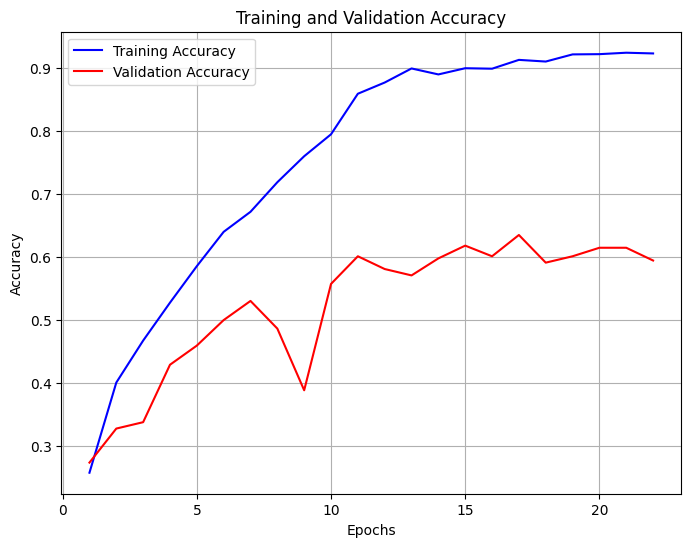

In [58]:
plot_accuracy(train_acc_arr, val_acc_arr)

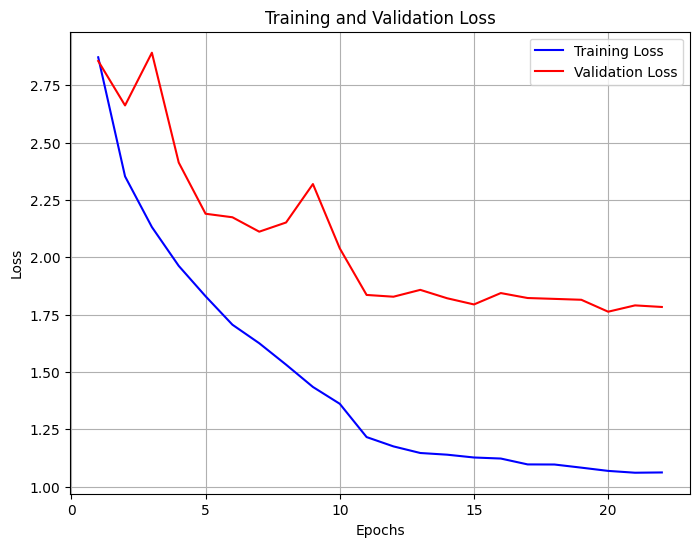

In [59]:
plot_loss(train_loss_arr, val_loss_arr)

In [60]:
test_dataset = GroceryStoreDataset(split='test', transform=val_transforms)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
model.load_state_dict(torch.load('best_grocery_cnn.pth'))
model.to(device)
test_loss, test_accuracy = evaluate_model_on_test_set(model, test_loader, criterion)

/tmp/ipykernel_24/3856395349.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_grocery_cnn.pth'))


Test Loss: 1.6562 | Test Accuracy: 0.6757


### PROVING THE MODEL
We decided to follow the ablation study approach. This means that we take out components of this networks (as well as reverting back some choices) in order to see how the performance is affected by these choices. 

In this first approach we remove the second convolutional block.

In [61]:
class EnhancedCNN_v2(nn.Module):
    def __init__(self, num_classes):
        super(EnhancedCNN_v2, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.batchnorm1 = nn.BatchNorm2d(64)
        self.batchnorm2 = nn.BatchNorm2d(128)

        # Global Average Pooling layer
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))

        # Fully connected layers
        self.fc1 = nn.Linear(128, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.batchnorm1(self.conv1(x))))
        x = self.pool(F.relu(self.batchnorm2(self.conv2(x))))
        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [62]:
#part 3, put everything together
from torch.utils.data import DataLoader
import torch.optim as optim
import torch
from torch.optim.lr_scheduler import StepLR
import copy

# Step 1: Define the device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the datasets
train_dataset = GroceryStoreDataset(split='train', transform=train_transforms)
val_dataset = GroceryStoreDataset(split='val', transform=val_transforms)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Initialize the model, loss function, and optimizer
num_classes = train_dataset.get_num_classes()
model = EnhancedCNN_v2(num_classes).to(device)
criterion = LabelSmoothingLoss(smoothing=0.1)
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)  


# Train the model with early stopping
trained_model, train_loss_arr, train_acc_arr, val_loss_arr, val_acc_arr = train_model_with_early_stopping_and_scheduler(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=30, patience=5)

# Save the best model
torch.save(trained_model.state_dict(), 'best_grocery_cnn.pth')


Epoch 1/30
Training Loss: 3.0607 Acc: 0.2167
Validation Loss: 2.9174 Acc: 0.2872
--------------------
Epoch 2/30
Training Loss: 2.6245 Acc: 0.3254
Validation Loss: 2.6852 Acc: 0.3514
--------------------
Epoch 3/30
Training Loss: 2.4512 Acc: 0.3731
Validation Loss: 2.5492 Acc: 0.3649
--------------------
Epoch 4/30
Training Loss: 2.2876 Acc: 0.4174
Validation Loss: 2.5613 Acc: 0.3581
--------------------
Epoch 5/30
Training Loss: 2.1632 Acc: 0.4663
Validation Loss: 2.6816 Acc: 0.3041
--------------------
Epoch 6/30
Training Loss: 2.0901 Acc: 0.4837
Validation Loss: 2.4459 Acc: 0.3818
--------------------
Epoch 7/30
Training Loss: 1.9733 Acc: 0.5231
Validation Loss: 2.4384 Acc: 0.3885
--------------------
Epoch 8/30
Training Loss: 1.9431 Acc: 0.5420
Validation Loss: 2.3707 Acc: 0.3953
--------------------
Epoch 9/30
Training Loss: 1.8642 Acc: 0.5720
Validation Loss: 2.2685 Acc: 0.4628
--------------------
Epoch 10/30
Training Loss: 1.8148 Acc: 0.5962
Validation Loss: 2.2475 Acc: 0.4392


We notice already a pretty big drop in performance

The next step is to remove BatchNormalization

In [63]:
class EnhancedCNN_v3(nn.Module):
    def __init__(self, num_classes):
        super(EnhancedCNN_v3, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        # Global Average Pooling layer
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))

        # Fully connected layers
        self.fc1 = nn.Linear(128, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [64]:
#part 3, put everything together
from torch.utils.data import DataLoader
import torch.optim as optim
import torch
from torch.optim.lr_scheduler import StepLR
import copy

# Step 1: Define the device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the datasets
train_dataset = GroceryStoreDataset(split='train', transform=train_transforms)
val_dataset = GroceryStoreDataset(split='val', transform=val_transforms)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Initialize the model, loss function, and optimizer
num_classes = train_dataset.get_num_classes()
model = EnhancedCNN_v3(num_classes).to(device)
criterion = LabelSmoothingLoss(smoothing=0.1)
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)  


# Train the model with early stopping
trained_model, train_loss_arr, train_acc_arr, val_loss_arr, val_acc_arr = train_model_with_early_stopping_and_scheduler(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=30, patience=5)

# Save the best model
torch.save(trained_model.state_dict(), 'best_grocery_cnn.pth')


Epoch 1/30
Training Loss: 3.2550 Acc: 0.1682
Validation Loss: 3.0384 Acc: 0.2128
--------------------
Epoch 2/30
Training Loss: 2.8542 Acc: 0.2530
Validation Loss: 2.8399 Acc: 0.2736
--------------------
Epoch 3/30
Training Loss: 2.6448 Acc: 0.3064
Validation Loss: 2.6585 Acc: 0.2973
--------------------
Epoch 4/30
Training Loss: 2.5223 Acc: 0.3413
Validation Loss: 2.6295 Acc: 0.2939
--------------------
Epoch 5/30
Training Loss: 2.3997 Acc: 0.3928
Validation Loss: 2.6060 Acc: 0.3480
--------------------
Epoch 6/30
Training Loss: 2.3208 Acc: 0.4057
Validation Loss: 2.6138 Acc: 0.3378
--------------------
Epoch 7/30
Training Loss: 2.2521 Acc: 0.4208
Validation Loss: 2.5841 Acc: 0.3581
--------------------
Epoch 8/30
Training Loss: 2.1445 Acc: 0.4705
Validation Loss: 2.5466 Acc: 0.3378
--------------------
Epoch 9/30
Training Loss: 2.0814 Acc: 0.4833
Validation Loss: 2.6076 Acc: 0.3007
--------------------
Epoch 10/30
Training Loss: 2.0203 Acc: 0.5098
Validation Loss: 2.4569 Acc: 0.3243


The performance drops again if this is done. We can now remove GlobalAveragePooling

In [65]:
class EnhancedCNN_v4(nn.Module):
    def __init__(self, num_classes):
        super(EnhancedCNN_v4, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 16 * 16, 512)  # Assumes input size is 64x64
        self.fc2 = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [66]:
#part 3, put everything together
from torch.utils.data import DataLoader
import torch.optim as optim
import torch
from torch.optim.lr_scheduler import StepLR
import copy

# Step 1: Define the device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the datasets
train_dataset = GroceryStoreDataset(split='train', transform=train_transforms)
val_dataset = GroceryStoreDataset(split='val', transform=val_transforms)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Initialize the model, loss function, and optimizer
num_classes = train_dataset.get_num_classes()
model = EnhancedCNN_v4(num_classes).to(device)
criterion = LabelSmoothingLoss(smoothing=0.1)
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)  


# Train the model with early stopping
trained_model, train_loss_arr, train_acc_arr, val_loss_arr, val_acc_arr = train_model_with_early_stopping_and_scheduler(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=30, patience=5)

# Save the best model
torch.save(trained_model.state_dict(), 'best_grocery_cnn.pth')


Epoch 1/30
Training Loss: 3.4713 Acc: 0.1511
Validation Loss: 3.2019 Acc: 0.1791
--------------------
Epoch 2/30
Training Loss: 2.7931 Acc: 0.2867
Validation Loss: 2.9461 Acc: 0.2500
--------------------
Epoch 3/30
Training Loss: 2.5116 Acc: 0.3670
Validation Loss: 2.8786 Acc: 0.2534
--------------------
Epoch 4/30
Training Loss: 2.3633 Acc: 0.4110
Validation Loss: 2.7548 Acc: 0.2872
--------------------
Epoch 5/30
Training Loss: 2.1836 Acc: 0.4758
Validation Loss: 2.8329 Acc: 0.2973
--------------------
Epoch 6/30
Training Loss: 2.0953 Acc: 0.5182
Validation Loss: 2.6834 Acc: 0.3176
--------------------
Epoch 7/30
Training Loss: 2.0316 Acc: 0.5394
Validation Loss: 2.6975 Acc: 0.3514
--------------------
Epoch 8/30
Training Loss: 1.9253 Acc: 0.5686
Validation Loss: 2.7259 Acc: 0.3209
--------------------
Epoch 9/30
Training Loss: 1.8679 Acc: 0.6004
Validation Loss: 2.6818 Acc: 0.3514
--------------------
Epoch 10/30
Training Loss: 1.8203 Acc: 0.6129
Validation Loss: 2.6521 Acc: 0.3311


This completes the ablation study and shows how the first model I proposed brings the best results. 

### Isolated step
In this last step, we check one more thing which goes to add value to the ablation study. We check if the main model (EnhancedCNN) performs as good with a simple CrossEntropyLoss instead of the LabelSmoothingLoss

In [67]:
#part 3, put everything together
from torch.utils.data import DataLoader
import torch.optim as optim
import torch
from torch.optim.lr_scheduler import StepLR
import copy

# Step 1: Define the device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the datasets
train_dataset = GroceryStoreDataset(split='train', transform=train_transforms)
val_dataset = GroceryStoreDataset(split='val', transform=val_transforms)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Initialize the model, loss function, and optimizer
num_classes = train_dataset.get_num_classes()
model = EnhancedCNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)  


# Train the model with early stopping
trained_model, train_loss_arr, train_acc_arr, val_loss_arr, val_acc_arr = train_model_with_early_stopping_and_scheduler(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=30, patience=5)

# Save the best model
torch.save(trained_model.state_dict(), 'best_grocery_cnn.pth')


Epoch 1/30
Training Loss: 3.1602 Acc: 0.1663
Validation Loss: 2.9250 Acc: 0.1926
--------------------
Epoch 2/30
Training Loss: 2.5536 Acc: 0.2511
Validation Loss: 2.5594 Acc: 0.2196
--------------------
Epoch 3/30
Training Loss: 2.2905 Acc: 0.2962
Validation Loss: 2.3693 Acc: 0.3176
--------------------
Epoch 4/30
Training Loss: 2.1183 Acc: 0.3568
Validation Loss: 2.4287 Acc: 0.2399
--------------------
Epoch 5/30
Training Loss: 2.0126 Acc: 0.3640
Validation Loss: 2.2003 Acc: 0.3243
--------------------
Epoch 6/30
Training Loss: 1.8715 Acc: 0.3985
Validation Loss: 2.1482 Acc: 0.3007
--------------------
Epoch 7/30
Training Loss: 1.7732 Acc: 0.4220
Validation Loss: 2.0833 Acc: 0.3277
--------------------
Epoch 8/30
Training Loss: 1.6529 Acc: 0.4564
Validation Loss: 2.1949 Acc: 0.3311
--------------------
Epoch 9/30
Training Loss: 1.5885 Acc: 0.4697
Validation Loss: 2.2035 Acc: 0.3176
--------------------
Epoch 10/30
Training Loss: 1.4738 Acc: 0.5064
Validation Loss: 2.1333 Acc: 0.3142


### Further Exploration:
In this next part we thought about exploring a different type of model, which would exploit residual blocks instead of a double convolutional block. This second type of model should work better in deeper contexts or when dealing with bigger datasets, and they should improve generalization. They are also more complex and can be too much if the context is too simple. The fact that the previous model performs well even if it is more simple suggests that residual blocks may not be needed in this case, therefore this part is completely out of curiosity and to propose an alternative solution. 

In [68]:
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.batchnorm1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.batchnorm2 = nn.BatchNorm2d(out_channels)

        # Shortcut connection
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = self.shortcut(x)
        out = F.relu(self.batchnorm1(self.conv1(x)))
        out = self.batchnorm2(self.conv2(out))
        out += identity
        out = F.relu(out)
        return out

class ResBlockCNN(nn.Module):
    def __init__(self, num_classes):
        super(EnhancedCNN, self).__init__()

        # First residual block
        self.res_block1 = ResidualBlock(3, 64, stride=1)
        self.res_block2 = ResidualBlock(64, 128, stride=2)

        # Second residual block
        self.res_block3 = ResidualBlock(128, 256, stride=2)
        self.res_block4 = ResidualBlock(256, 512, stride=2)

        # Global Average Pooling layer instead of flattening
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))  # Output size of 1x1

        # Fully connected layers
        self.fc1 = nn.Linear(512, 1024)
        self.fc2 = nn.Linear(1024, num_classes)

        # Regularization
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # Residual blocks
        x = self.res_block1(x)
        x = self.res_block2(x)
        x = self.res_block3(x)
        x = self.res_block4(x)

        # Global Average Pooling
        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [69]:
#part 3, put everything together
from torch.utils.data import DataLoader
import torch.optim as optim
import torch
from torch.optim.lr_scheduler import StepLR
import copy

# Step 1: Define the device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the datasets
train_dataset = GroceryStoreDataset(split='train', transform=train_transforms)
val_dataset = GroceryStoreDataset(split='val', transform=val_transforms)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Initialize the model, loss function, and optimizer
num_classes = train_dataset.get_num_classes()
model = ResBlockCNN(num_classes).to(device)
criterion = LabelSmoothingLoss(smoothing=0.1)
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)  


# Train the model with early stopping
trained_model, train_loss_arr, train_acc_arr, val_loss_arr, val_acc_arr = train_model_with_early_stopping_and_scheduler(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=30, patience=5)

# Save the best model
torch.save(trained_model.state_dict(), 'best_grocery_cnn.pth')


TypeError: super(type, obj): obj must be an instance or subtype of type

## Part 2: fine-tune an existing network

Your goal is to fine-tune a pretrained **ResNet-18** model on `GroceryStoreDataset`. Use the implementation provided by PyTorch, do not implement it yourselves! (i.e. exactly what you **could not** do in the first part of the assignment). Specifically, you must use the PyTorch ResNet-18 model pretrained on ImageNet-1K (V1). Divide your fine-tuning into two parts:

1. First, fine-tune the Resnet-18 with the same training hyperparameters you used for your best model in the first part of the assignment.
1. Then, tweak the training hyperparameters in order to increase the accuracy on the validation split of `GroceryStoreDataset`. Justify your choices by analyzing the training plots and/or citing sources that guided you in your decisions (papers, blog posts, YouTube videos, or whatever else you find enlightening). You should consider yourselves satisfied once you obtain a classification accuracy on the **validation** split **between 80 and 90%**.